### Performance of the MMC stopping rule on synthetic data

In [3]:
from plurality_stopping_rule_beta import PluralityEAndDecider
from plurality_stopping_rule_point_prior import PluralityEAndDeciderPrior
from plurality_stopping_rule_point_prior_ratio_update import PluralityEAndDeciderPriorRatioUpdate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [4]:
def simulation(N, n_inner, concentration_dirichlet= [0.3, 0.3, 0.3, 0.1]):
    probability_gap = []
    truncated_beta_votes = []
    delta_dirac_votes = []
    delta_dirac_ratio_votes = []

    len_labels = 26
    true_p = np.zeros(len_labels)
    concentration = np.zeros(len_labels)
    concentration[0] = concentration_dirichlet[0]
    concentration[1] = concentration_dirichlet[1]
    concentration[2] = concentration_dirichlet[2]
    concentration[3:] = concentration_dirichlet[3] / (len_labels - 3)

    for _ in range(N):
        # 1) Create a true distribution with a dirichlet prior
        
        # sample a random dirichlet distribution as the true distribution
        true_p = np.random.dirichlet(concentration, size=1)[0]

        # find argmax of true_p
        argmax_idx = np.argmax(true_p)
        gap = np.max(true_p)-np.max(np.delete(true_p, argmax_idx))
        probability_gap.append(gap)

        n_votes_beta = []
        n_votes_delta = []
        n_votes_delta_ratio = []
        for _ in range(n_inner):

            # 2) Configure decider for stopping rule with truncated beta prior
            decider = PluralityEAndDecider(
                labels=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"],  # optional; can be empty if unknown
                M=2,
                delta=0.1,
                N_max=64,
                min_pair_updates=1,
                min_other_updates=1,
                require_current_leader_match=False,
                grid_K=101,
            )

            # 3) Feed votes one-by-one 
            v_vector = []
            while True:      
                v = int(np.random.choice(len(true_p), p=true_p))
                v_vector.append(v)
                diag = decider.on_vote(decider.labels[v])
                if diag["stopped"] or diag["abstained"]:
                    break  # decision made (or abstained at budget)
            n_votes_beta.append(len(v_vector))

            # 4) Configure decider for stopping rule with updating point prior (shared parameter)
            decider_prior = PluralityEAndDeciderPrior(
                labels=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"],  # optional; can be empty if unknown
                M=2,
                delta=0.1,
                N_max=64,
                min_pair_updates=1,
                min_other_updates=1,
                require_current_leader_match=False,
            )

            # 5) Now test the prior-based stopping rule on the same votes
            nvotes = len(v_vector)  # number of votes generated until stopping using truncated beta prior-stopping rule
            i = 0
            while True:      
                if i < nvotes:
                    v = v_vector[i]
                else:
                    v = int(np.random.choice(len(true_p), p=true_p))
                i = i + 1
                diag = decider_prior.on_vote(decider_prior.labels[v])
                if diag["stopped"] or diag["abstained"]:
                    break  # decision made (or abstained at budget)

            n_votes_delta.append(i)

            # 6) Configure decider for stopping rule with updating point prior (ratio update)
            decider_prior = PluralityEAndDeciderPriorRatioUpdate(
                labels=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"],  # optional; can be empty if unknown
                M=2,
                delta=0.1,
                N_max=64,
                min_pair_updates=1,
                min_other_updates=1,
                require_current_leader_match=False,
            )

            # 7) Now test the prior-based stopping rule on the same votes
            j = 0
            while True:      
                if j < nvotes:
                    v = v_vector[j]
                else:
                    v = int(np.random.choice(len(true_p), p=true_p))
                j = j + 1
                diag = decider_prior.on_vote(decider_prior.labels[v])
                if diag["stopped"] or diag["abstained"]:
                    break  # decision made (or abstained at budget)

            n_votes_delta_ratio.append(j)

        truncated_beta_votes.append(n_votes_beta)
        delta_dirac_votes.append(n_votes_delta)
        delta_dirac_ratio_votes.append(n_votes_delta_ratio)

    return np.array(probability_gap), truncated_beta_votes, delta_dirac_votes, delta_dirac_ratio_votes

In [5]:
# Run simulation
N = 55  # number of different true distributions
n_inner = 60  # number of repetitions per true distribution
probability_gap, truncated_beta_votes, delta_dirac_votes, delta_dirac_ratio_votes = simulation(N, n_inner)
probability_gap_orig = probability_gap.copy()

In [25]:
# Find the closest value from the probability gap vector to each value in target_positions
# To avoid a messy plot
n_show = 20
target_positions = np.linspace(0, 1, n_show)
indices = [np.argmin(np.abs(probability_gap_orig - t)) for t in target_positions]

prob_gap_sub = probability_gap_orig[indices]
trunc_beta_sub = [truncated_beta_votes[i] for i in indices]
delta_dirac_sub = [delta_dirac_votes[i] for i in indices]
delta_dirac_ratio_sub = [delta_dirac_ratio_votes[i] for i in indices]

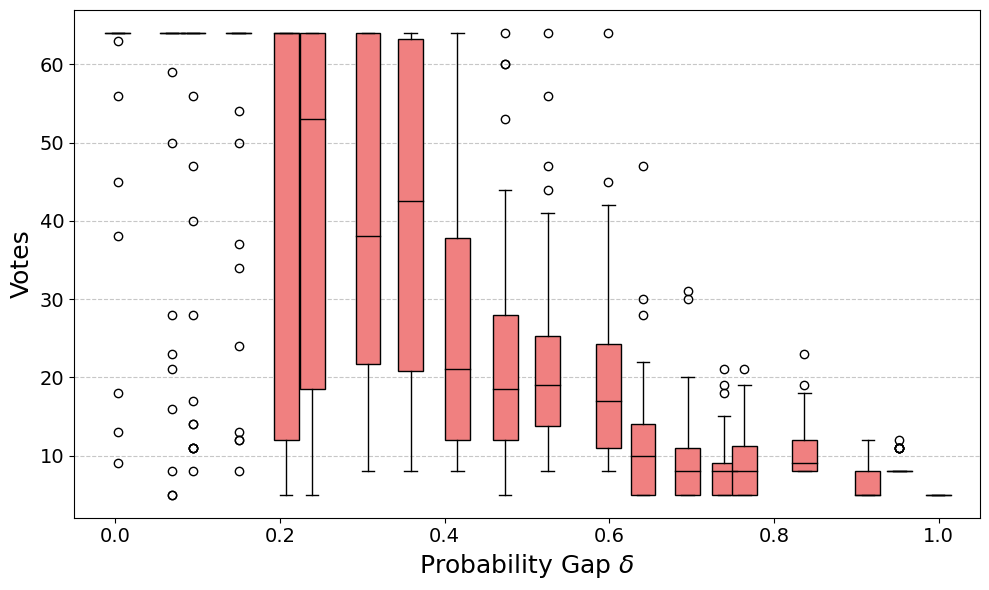

In [ ]:
positions_dirac = prob_gap_sub 

# Create boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(delta_dirac_sub, positions=positions_dirac, widths=0.03, patch_artist=True,
            boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="black"))

# Formatting
plt.xlim(-0.05, 1.05)
explicit_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
plt.xticks(explicit_ticks, [f"{t:.1f}" for t in explicit_ticks], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Probability Gap $\delta$", fontsize=18)
plt.ylabel("Votes", fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("synthetic_point_prior_stopping.pdf")

plt.show()

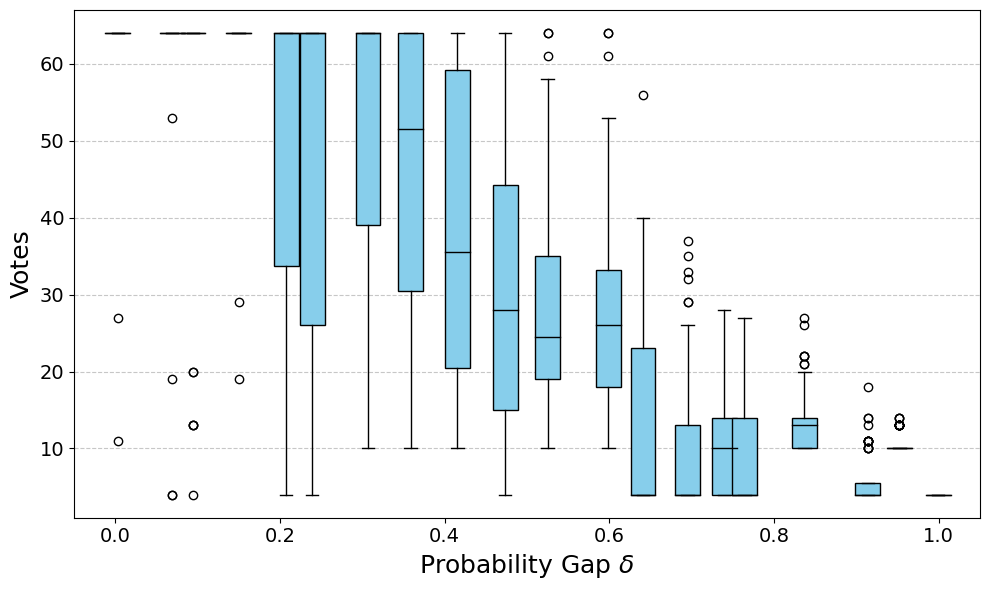

In [ ]:
# Width offset for side-by-side boxplots

positions_beta = prob_gap_sub 

# Create boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(trunc_beta_sub, positions=positions_beta, widths=0.03, patch_artist=True,
            boxprops=dict(facecolor="skyblue"), medianprops=dict(color="black"))

# Formatting
plt.xlim(-0.05, 1.05)
explicit_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
plt.xticks(explicit_ticks, [f"{t:.1f}" for t in explicit_ticks], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Probability Gap $\delta$", fontsize=18)
plt.ylabel("Votes", fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("synthetic_truncated_beta_prior_stopping.pdf")

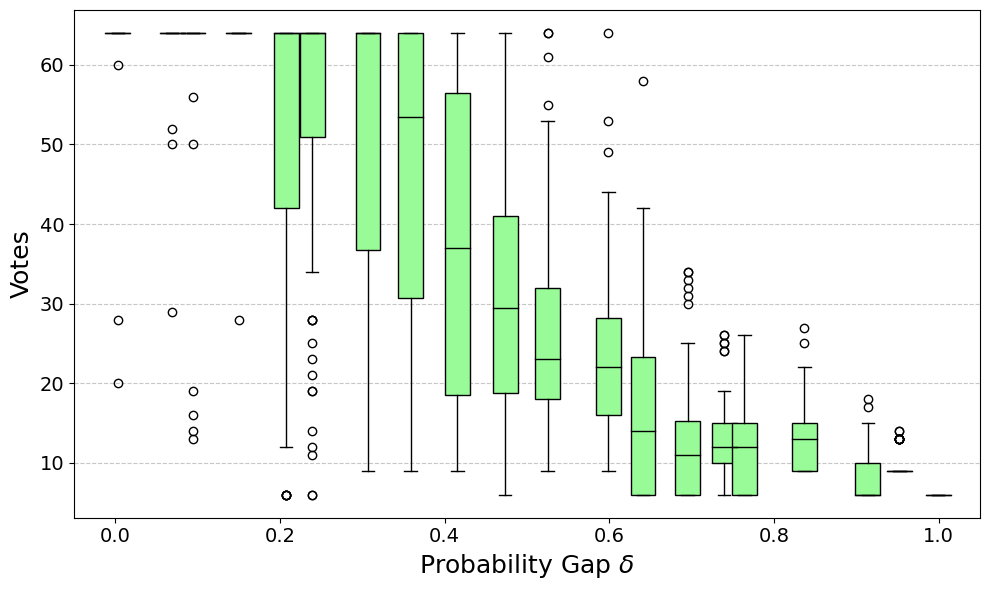

In [ ]:
# Width offset for side-by-side boxplots

positions_dirac_update = prob_gap_sub 

# Create boxplots
plt.figure(figsize=(10, 6))
plt.boxplot(delta_dirac_ratio_sub, positions=positions_dirac_update, widths=0.03, patch_artist=True,
            boxprops=dict(facecolor="palegreen"), medianprops=dict(color="black"))

# Formatting
plt.xlim(-0.05, 1.05)
explicit_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] 
plt.xticks(explicit_ticks, [f"{t:.1f}" for t in explicit_ticks], fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Probability Gap $\delta$", fontsize=18)
plt.ylabel("Votes", fontsize=18)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("synthetic_point_prior_ratio_stopping.pdf")